In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from sklearn import utils
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords

from gensim.models import Word2Vec  
from gensim.models.doc2vec import TaggedDocument
from gensim.models import KeyedVectors

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

unable to import 'smart_open.gcs', disabling that module
Using TensorFlow backend.


## Preprocess

In [3]:
aita_raw = pd.read_csv("data/processed/aita_xy_cleaned_full.csv", index_col=0)

def pp_regularize_text(df, body_or_title):
    stop_words = []
    for word in list(stopwords.words('english')):
        word = re.sub(r'[^A-Za-z ]+', '', word)
        stop_words.append(word)

    text_list = []
    for text in df[body_or_title]:
        text = text.lower()
        text = text.replace('\n', ' ').replace('\r', '').replace('’', '\'')
        text = re.sub(r'[^A-Za-z ]+', '', text)
        goodtext = text.encode('cp1252', 'ignore')
        goodtext = goodtext.decode('utf-8', 'ignore')

        token = nltk.word_tokenize(goodtext)
        token = [y for y in token if not y in stop_words]
        final_text = (" ").join(token)

        text_list.append(final_text)
    df[body_or_title] = text_list
    return df

aita_raw = pp_regularize_text(aita_raw, "body")
aita_raw = pp_regularize_text(aita_raw, "title")
print(aita_raw.shape)
aita_raw.head()

(20800, 4)


,target,binary_target,title,body
0,NTA,0,aita renting house telling neighbors go landlo...,house rent neighbors complaints property maint...
1,NTA,0,aita boyfriend let get breast reduction,tldr large breasts caused nothing back pain bo...
2,NTA,0,aita parents took wardrobe away punishment sai...,got trouble school fall im junior high school ...
3,YTA,1,aita going week long vacation without wife yea...,ill try make short im wife f married years met...
4,NTA,0,wibta warned current coworkers new problematic...,im senior broadcast producer manager announced...


In [4]:
def undersample_and_limit_targets(df):
    minor = df[df["target"] == "YTA"]
    major = df[df["target"] == "NTA"]
    major = major.sample(n=len(minor))
    us_df = pd.concat([minor, major])
    return us_df

us_df = undersample_and_limit_targets(aita_raw)
us_df[["target", "title"]].groupby("target").count()

,title
target,
NTA,4115
YTA,4115


In [5]:
x_body = list(aita_raw["body"])
print(len(x_body))
y_target = list(aita_raw["binary_target"])
print(len(y_target))

20800
20800


## Training Word2Vec

In [6]:
def label_sentence(x, label):
    labeled_list = []
    for count in range(len(x)):
        label_count = "%s_%s" % (label, count)
        labeled_list.append(TaggedDocument(x[count].split(), label_count))
    return labeled_list

x_tagged = label_sentence(x_body, "body")

In [7]:
w2v_cbow = Word2Vec(sg=0, size=100, negative=5, window=2, min_count=2)
w2v_cbow.build_vocab([x.words for x in tqdm(x_tagged)])

100%|██████████| 20800/20800 [00:00<00:00, 1667237.24it/s]


In [8]:
for epoch in range(15):
    w2v_cbow.train(utils.shuffle([x.words for x in tqdm(x_tagged)]), total_examples=len(x_tagged), epochs=1)
    w2v_cbow.alpha -= 0.002
    w2v_cbow.min_alpha = w2v_cbow.alpha

100%|██████████| 20800/20800 [00:00<00:00, 2087417.41it/s]


In [15]:
w2v_cbow.save('data/processed/w2v_cbow.word2vec')

In [16]:
w2v_sg = Word2Vec(sg=0, size=100, negative=5, window=2, min_count=2)
w2v_sg.build_vocab([x.words for x in tqdm(x_tagged)])

100%|██████████| 20800/20800 [00:00<00:00, 1737775.10it/s]


In [17]:
for epoch in range(15):
    w2v_sg.train(utils.shuffle([x.words for x in tqdm(x_tagged)]), total_examples=len(x_tagged), epochs=1)
    w2v_sg.alpha -= 0.002
    w2v_sg.min_alpha = w2v_sg.alpha

100%|██████████| 20800/20800 [00:00<00:00, 1887813.46it/s]


In [31]:
w2v_sg.save('data/processed/w2v_sg.word2vec')

In [32]:
w2v_cbow.most_similar("jerk")

[('ah', 0.7965837717056274),
 ('dick', 0.7795826196670532),
 ('hypocrite', 0.7074277400970459),
 ('ahole', 0.7033635973930359),
 ('bitch', 0.6969475150108337),
 ('douche', 0.6944093108177185),
 ('idiot', 0.6936898231506348),
 ('asshole', 0.6820759177207947),
 ('overreacted', 0.6750144958496094),
 ('creep', 0.6704512238502502)]

In [33]:
w2v_sg.most_similar("jerk")

[('dick', 0.7928402423858643),
 ('ah', 0.7912259101867676),
 ('ahole', 0.7249943614006042),
 ('bitch', 0.7207160592079163),
 ('idiot', 0.7031358480453491),
 ('asshole', 0.6907906532287598),
 ('selfish', 0.6898930072784424),
 ('immature', 0.6855732202529907),
 ('douche', 0.6800611019134521),
 ('overreacting', 0.6691429615020752)]

## Tokenization

In [34]:
X_train, X_test, y_train, y_test = train_test_split(x_body, y_target, test_size=0.25, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print(len(X_train), len(X_test))

11700 5200


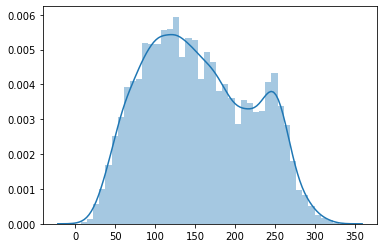

In [35]:
length = []
for x in x_body:
    length.append(len(x.split()))
sns.distplot(length)

In [36]:
def tokenize(df, body_or_title):
    tokenizer = Tokenizer(num_words=100000)
    tokenizer.fit_on_texts(df[body_or_title])
    return tokenizer

def pp_token_sequence_pad(list_docs, tokenizer):
    seq = tokenizer.texts_to_sequences(list_docs)
    seq = pad_sequences(seq, maxlen=300)
    return seq

In [37]:
tokenizer = tokenize(aita_raw, "body")
seq_train = pp_token_sequence_pad(X_train, tokenizer)
seq_val = pp_token_sequence_pad(X_val, tokenizer)
seq_test = pp_token_sequence_pad(X_test, tokenizer)

In [38]:
X_test[4]

'happened last saturday want start giving background year old male living three women one man four bedroom house split rent four ways live moderate walking distance university one us attend alabama originally california la specific lease early next year planning ditching day fucking intolerable people woken minimum four days week somebody shouting something somebody else girl boyfriend frequent meltdowns occasionally take onto front lawn causing neighbors surrounding houses come stare humiliating guy lives house people get shouting matches regularly whenever start go room close door put headphones ignore neighbors crap blame naturally often deemed guilty association last saturday around morning began one arguments playing wow happily room loud time even concentrate woman shouted leaving usual pretending pack shit car boyfriend followed started typical shouting match front lawn point shit frankly could give less fuck put raggedy pair boxers wife beater fully accentuated gut chest hair g

In [39]:
seq_test[4]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
         181,    59,   952,     9,   220,   327,   486,    43,    97,
         840,   208,   276,   539,     8,   293,   713,   559,    41,
         588,   349,   713,  1052,   106,  8380,   543,  1395,   751,
           8,    23,   881, 10687,  1360,  2791,  4903,  1245,  1164,
         363,   114,    43,   421,  6049,    31,   434, 16292,    24,
        2863,  1623,

## W2V Dictonary to Docs

In [42]:
w2v_cbow = KeyedVectors.load('data/processed/w2v_cbow.word2vec')
w2v_sg = KeyedVectors.load('data/processed/w2v_sg.word2vec')

In [43]:
print(len(w2v_cbow.wv.vocab.keys()))
print(len(w2v_sg.wv.vocab.keys()))

28542
28542


In [44]:
w2v_dict = {}
for w in w2v_cbow.wv.vocab.keys():
    w2v_dict[w] = np.append(w2v_cbow.wv[w],w2v_sg.wv[w])
print(len(w2v_dict))

28542


In [45]:
num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = w2v_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape

(100000, 200)

In [47]:
np.array_equal(embedding_matrix[170] ,w2v_dict.get('situation'))

False

In [46]:
np.array_equal(embedding_matrix[180] ,w2v_dict.get('situation'))

True

## CNN

In [48]:
seed = 7

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [49]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=300, trainable=False)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(seq_train, y_train, validation_data=(seq_val, y_val), epochs=5, batch_size=32, verbose=2)

Train on 11700 samples, validate on 3900 samples
Epoch 1/5
 - 63s - loss: 1.8813 - accuracy: 0.6464 - val_loss: 0.8635 - val_accuracy: 0.5751
Epoch 2/5
 - 64s - loss: 0.4899 - accuracy: 0.7866 - val_loss: 0.7654 - val_accuracy: 0.6200
Epoch 3/5
 - 64s - loss: 0.3270 - accuracy: 0.8562 - val_loss: 0.9419 - val_accuracy: 0.5654
Epoch 4/5
 - 64s - loss: 0.2800 - accuracy: 0.8764 - val_loss: 1.2326 - val_accuracy: 0.7526
Epoch 5/5
 - 65s - loss: 0.2640 - accuracy: 0.8863 - val_loss: 0.9092 - val_accuracy: 0.6459


In [50]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=300, trainable=True)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(seq_train, y_train, validation_data=(seq_val, y_val), epochs=5, batch_size=32, verbose=2)

Train on 11700 samples, validate on 3900 samples
Epoch 1/5
 - 170s - loss: 1.0730 - accuracy: 0.7040 - val_loss: 0.5494 - val_accuracy: 0.7628
Epoch 2/5
 - 159s - loss: 0.4878 - accuracy: 0.7697 - val_loss: 0.7499 - val_accuracy: 0.7628
Epoch 3/5
 - 159s - loss: 0.3623 - accuracy: 0.8395 - val_loss: 0.7398 - val_accuracy: 0.7564
Epoch 4/5
 - 158s - loss: 0.2115 - accuracy: 0.9162 - val_loss: 0.9805 - val_accuracy: 0.7295
Epoch 5/5
 - 159s - loss: 0.0996 - accuracy: 0.9675 - val_loss: 1.2546 - val_accuracy: 0.7338
